<h1>Translateam</h1>

In [1]:
import io
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.utils import extmath 
import torch
from torch.optim.lr_scheduler import StepLR
import time
import scipy
import matplotlib.pyplot as plt

# Data Import


In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fr.vec
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ru.vec
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.es.vec
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.it.vec
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.0-5000.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.5000-6500.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/fr-en.0-5000.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/fr-en.5000-6500.txt  
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-es.0-5000.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-es.5000-6500.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-ru.0-5000.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-ru.5000-6500.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/ru-en.0-5000.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/ru-en.5000-6500.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-it.0-5000.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-it.5000-6500.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/es-it.0-5000.txt
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/es-it.5000-6500.txt


--2021-11-17 15:39:22--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fr.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3027096151 (2.8G) [binary/octet-stream]
Saving to: ‘wiki.fr.vec’

wiki.fr.vec         100%[===================>]   2.82G  10.5MB/s    in 4m 34s  

2021-11-17 15:43:57 (10.5 MB/s) - ‘wiki.fr.vec’ saved [3027096151/3027096151]

--2021-11-17 15:43:57--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ru.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4954492872 (4.6G) [binary/octet-stream]
Saving to: ‘wiki.ru.vec’

wiki.ru.vec      

In [5]:
def load_vec(emb_path, nmax=50000, Normed=False):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            if Normed==True:
                vectors.append(vect/np.linalg.norm(vect)) #Normalisation of vect
            else:
                vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [7]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    """Function to see the nearest-neighbor of a word from the src_emb in the tgt_emb"""
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [42]:
src_path = 'wiki.fr.vec'
targ_path = 'wiki.en.vec'

src_embeddings, src_id2word, src_word2id = load_vec(src_path, 200000, False)
targ_embeddings, targ_id2word, targ_word2id = load_vec(targ_path, 200000, False)

In [43]:
df_train = pd.read_csv("fr-en.0-5000.txt", sep=" ", header = None, na_filter= False)
df_test = pd.read_csv("fr-en.5000-6500.txt", sep=" ", header = None, na_filter=False)

# Check if there is NaN value
print(df_test.isna().values.any())

False


In [44]:
df_train['SrcEmbed'] = df_train[0].apply(lambda k: src_embeddings[src_word2id[k]])
df_train['TgtEmbed'] = df_train[1].apply(lambda k: targ_embeddings[targ_word2id[k]])
df_test['SrcEmbed'] = df_test[0].apply(lambda k: src_embeddings[src_word2id[k]])
df_test['TgtEmbed'] = df_test[1].apply(lambda k: targ_embeddings[targ_word2id[k]])

In [45]:
def build_dico(src_words, tgt_words):
    """Function ton build a python dictionnary to pair a src word (key) to his translation """

    dico = {}
    for (word1, word2) in zip(src_words, tgt_words):
        if word1 in dico.keys():
            dico[word1].append(word2)
        else:
            dico[word1] = [word2]

    return dico

# Class to perform all our supervised Linear Transformation

In [47]:
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


class linear_transform:

    def __init__(self, X, Z, src_words, tgt_words):
        self.X = X
        self.Z = Z
        self.n = self.X.shape[1]
        self.W = np.random.random((self.n, self.n))
        self.dico = build_dico(src_words, tgt_words)
        self.src_words = src_words


    def score(self):
        preds = model.predict(self.X, targ_embeddings,  targ_id2word)
        acc = accuracy(self.src_words, preds, self.dico)
        return acc


    def fit(self, learning_rate=0.000322, n_iter=100, ortho=True):
        """Gradient Descent with or without orthogonalization"""
        cpt = 0
        print(self.score())
        while cpt < n_iter:
            cpt += 1
            gradient = self.X.T @ (self.X @ self.W - self.Z)
            self.W = self.W - learning_rate * gradient

            if ortho:
                Q, E, P = linalg.svd(self.W, full_matrices=True)
                self.W = Q.dot(P)
                # print(np.round(self.W @ self.W.T))

            print(self.score())


    def fit_cosine(self, learning_rate=0.1, n_iter=100, ortho=True):
        """Gradient Descent with the second problem to maximize the cosine similarity"""
        cpt = 0
        print(self.score())
        gradient = np.zeros_like(self.W)
        for i in range(self.n):
            gradient += np.outer(self.X[i],self.Z[i])
        print(gradient)
        print(gradient.shape)
        while cpt < n_iter:
            print(cpt)
            cpt += 1

            self.W = self.W + learning_rate * gradient
            if ortho:
                Q, E, P = scipy.linalg.svd(self.W, full_matrices=True)
                E[E != 0] = 1
                self.W = Q.dot(P)
                # print(np.round(self.W @ self.W.T))

            print(self.score())


    def fit_sgd(self, learning_rate=0.1, n_iter=1000, ortho=True):
        """Stochastic Gradient Descent with or without orthogonalization"""
        print('X :', self.X.shape)
        print('W :', self.W.shape)
        print('Z :', self.Z.shape)
        cpt = 0
        S = list(range(self.W.shape[0]))
        print(self.score())
        while cpt < n_iter:
            np.random.shuffle(S)
            for i in S:
                error = self.X[i][:] @ self.W - self.Z[i][:]
                gradient =  np.dot(self.X[i][:][:,None], error[None, :])
                self.W = self.W - learning_rate * gradient
            cpt += 1

            if ortho:
                Q, E, P = linalg.svd(self.W, full_matrices=True)
                E[E != 0] = 1
                self.W = Q.dot(np.diag(E)).dot(P)
                # print(np.round(self.W @ self.W.T))

            print(self.score())

    def procrustes(self):
      U, _, V = linalg.svd(self.X.T.dot(self.Z), full_matrices=True)
      self.W = U.dot(V)

            



    def ols(self, ortho=True):
        least_square = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.Z
        self.W = least_square
        if ortho:
            Q, E, P = linalg.svd(self.W, full_matrices=True)
            E[E != 0] = 1
            self.W = Q.dot(np.diag(E)).dot(P)

    def fit_ortho(self, learning_rate = 0.1, n_iter = 100):
        
        for i in range(n_iter):
            gradW=np.zeros_like(self.W)
            for j in range(self.X.shape[0]):
                gradW+=np.outer(self.X[j],self.Z[j])
                
            self.W = self.W + learning_rate*gradW
            u, s, vT = np.linalg.svd(self.W)
            self.W = np.dot(u,vT)
        print('Model FITTED')

    def predict(self, test_set, tgt_emb, tgt_id2word):
        preds = []
        word_emb = np.dot(test_set,self.W)

        # Here we can change CSLS with cosine_similarity() to have a NN prediction
        scores = CSLS(word_emb, tgt_emb)
        best_cos_sim = scores.argmax(axis=1)
        for i in best_cos_sim:
            preds.append(tgt_id2word[i])
        print("predict1 DONE.")
        return(preds)
    
    
    def predict_5best(self, test_set, tgt_emb, tgt_id2word):
        word_emb = np.dot(test_set,self.W)
        scores = CSLS(word_emb, tgt_emb)
        best_5 = scores.argsort(axis=1)[:,-5:]
        for elems in best_5:
            pred=[]
            for i in elems:
                pred.append(tgt_id2word[i])
            preds.append(pred)
        print("predict5 DONE.")
        return(preds)



In [48]:
def accuracy(src_words, preds,  dico):
    acc = 0
    src_words = np.array(list(src_words))
    _, idx = np.unique(np.array(list(src_words)), return_index=True)
    src_words = src_words[np.sort(idx)]

    preds = np.array(preds)
    preds = preds[np.sort(idx)]

    for (word1, pred) in zip(src_words, preds):
        if pred in dico[word1]:
            acc +=1
    
    return round(acc / len(preds) * 100, 2)
      

In [49]:
def get_nn_avg_dist(emb, query, knn=10):
    """Function to compute the average similarity of word's neighborhood """
    bs = 32
    emb = torch.Tensor(emb)
    query = torch.Tensor(query)
    all_distances = []
    emb = emb.transpose(0, 1).contiguous()
    for i in range(0, query.shape[0], bs):
        distances = query[i:i + bs].mm(emb)
        best_distances, _ = distances.topk(knn, dim=1, largest=True, sorted=True)
        all_distances.append(best_distances.mean(1).cpu())
    all_distances = torch.cat(all_distances)
    return all_distances.numpy()


In [50]:
def CSLS(src_emb, tgt_emb):
    src_emb = torch.from_numpy(src_emb)
    tgt_emb = torch.from_numpy(tgt_emb)
    src_emb = src_emb / src_emb.norm(2, 1, keepdim=True).expand_as(src_emb)
    tgt_emb = tgt_emb / tgt_emb.norm(2, 1, keepdim=True).expand_as(tgt_emb)
    src_emb = src_emb.numpy()
    tgt_emb = tgt_emb.numpy()
    cosine = cosine_similarity(src_emb, tgt_emb)
    src_avg = get_nn_avg_dist(tgt_emb, src_emb)
    
    tgt_avg = get_nn_avg_dist(src_emb, tgt_emb)
    cosine = np.subtract(2 * cosine, tgt_avg)
    csls_val = np.subtract(cosine.T, src_avg).T

    return csls_val


In [51]:
def get_similars(embedd1, embedd2):
      """Build a dictionnary with mutual nearest-neighbor"""
      print("Getting similars...")
      src_scores = CSLS(embedd1, embedd2)
      best_src_scores = src_scores.argmax(axis=1)
      src_similar = {(a, b) for a, b in enumerate(best_src_scores)}
      tgt_scores = CSLS(embedd2, embedd1)
      best_tgt_scores = tgt_scores.argmax(axis=1)
      tgt_similar = {(b, a) for a, b in enumerate(best_tgt_scores)}
      
      dico = list(src_similar.intersection(tgt_similar))
      test = list(src_similar)
      test2 =list(tgt_similar)
      test.sort()
      test2.sort()
      dico.sort()
      print("Dictionnary built.")
      return dico


## Training with procrustes

In [54]:
dico_src_tgt = build_dico(df_test[0], df_test[1])
model = linear_transform(np.array(list(df_train['SrcEmbed'])), np.array(list(df_train['TgtEmbed'])), df_train[0], df_train[1])
t = time.time()
model.procrustes()
t2 = time.time() - t
print("Fitting done in {} sec.".format(np.round(t2, 2)))

t = time.time()

preds  = model.predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print("Accuracy : {} %.".format(accuracy(df_test[0], preds, dico_src_tgt)))
t2 = time.time() - t
print("Fitting done in {} sec.".format(np.round(t2, 2)))


Fitting done in 0.11 sec.
predict1 DONE.
Accuracy : 76.07 %.
Fitting done in 5.86 sec.


In [56]:
# Translation of 1 word 

src_word = 'amour'
get_nn(src_word,  src_embeddings @ model.W , src_id2word, targ_embeddings, targ_id2word, K=5)

Nearest neighbors of "amour":
0.7573 - love
0.6236 - longing
0.6207 - unrequited
0.6174 - lover
0.5960 - lovers


# Vocabulary Clustering

## Silhouette & Elbow Method to find the best K

Iteration 2 / 19
Iteration 3 / 19
Iteration 4 / 19
Iteration 5 / 19
Iteration 6 / 19
Iteration 7 / 19
Iteration 8 / 19
Iteration 9 / 19
Iteration 10 / 19
Iteration 11 / 19
Iteration 12 / 19
Iteration 13 / 19
Iteration 14 / 19
Iteration 15 / 19
Iteration 16 / 19
Iteration 17 / 19
Iteration 18 / 19
Iteration 19 / 19
Iteration 20 / 19


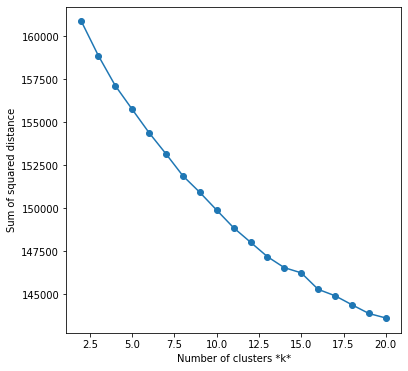

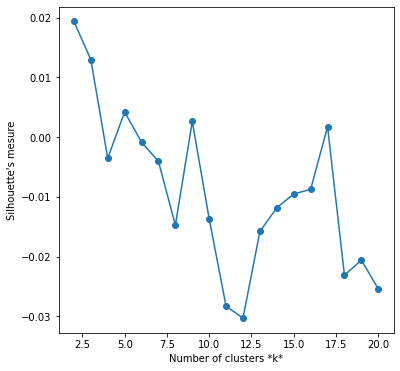

In [30]:
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score

    
def silhouette_elbow_method(X, list_k):
    errors = []
    sil = []
    for k in list_k:
        print("Iteration {} / {}".format(k, len(list_k)))
        kmeans = KMeans(k)
        kmeans.fit(X)
        errors.append(kmeans.inertia_)
        labels = kmeans.labels_
        sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, errors, '-o')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance')
    plt.plot()
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sil, '-o')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel("Silhouette's mesure")

list_k = list(range(2,21))

df_train_normalized = np.array(list(df_train["SrcEmbed"])) / np.linalg.norm(np.array(list(df_train["SrcEmbed"])), 2, 1, keepdims = True)
silhouette_elbow_method(np.array(list(df_train["SrcEmbed"])), list_k)

## K-Means training 

In [32]:
df_test_normalized = np.array(list(df_test["SrcEmbed"])) / np.linalg.norm(np.array(list(df_test["SrcEmbed"])), 2, 1, keepdims = True)
kmeans = KMeans(4)
kmeans.fit(df_train_normalized)
labels_train = kmeans.labels_
labels_test = kmeans.predict(df_test_normalized )
print("Size of labels test", len(labels_test))

Size of labels test 2943


## Comparison between vocabulary and global training

In [36]:
k_label = 3
#print(np.array(list(df_train[0]))[labels_train == k_label][:200])
preds  = model.predict(np.array(list(df_test['SrcEmbed']))[labels_test == k_label], targ_embeddings,  targ_id2word)
dico_src_tgt_labeled = build_dico(df_test[0][labels_test == k_label], df_test[1][labels_test == k_label])
print("Accuracy of the {}th vocab without specific training: {} %.".format(k_label, accuracy(df_test[0][labels_test == k_label], preds, dico_src_tgt)))

dico_src_tgt = build_dico(df_test[0], df_test[1])
model_labeled = linear_transform(np.array(list(df_train['SrcEmbed']))[labels_train == k_label], np.array(list(df_train['TgtEmbed']))[labels_train== k_label], df_train[0][labels_train == k_label], df_train[1][labels_train == k_label])
t = time.time()
model_labeled.procrustes()
t2 = time.time() - t
print("Fitting done in {} sec.".format(np.round(t2, 2)))

t = time.time()

preds  = model_labeled.predict(np.array(list(df_test['SrcEmbed']))[labels_test == k_label], targ_embeddings,  targ_id2word)
print("Accuracy of the {}th vocab with specific training: {} %.".format(k_label, accuracy(df_test[0][labels_test == k_label], preds, dico_src_tgt)))
t2 = time.time() - t
print("Fitting done in {} sec.".format(np.round(t2, 2)))

predict1 DONE.
Accuracy of the 3th vocab without specific training: 65.56 %.
Fitting done in 0.06 sec.
predict1 DONE.
Accuracy of the 3th vocab with specific training: 66.23 %.
Fitting done in 3.88 sec.


### GAN

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import device

# Hyperparameters
D = 300
learning_rate = 0.1
decay = 0.98
batch_size = 32
epochs = 40
smooth = 0.2
n_refinement = 5


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Generator(nn.Module):

    def __init__(self, id_init = True):
        super(Generator, self).__init__()
        self.W = nn.Linear(D, D, bias=False)
        if id_init :
          self.W.weight.data.copy_(torch.diag(torch.ones(D)))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.W(x)
        return x

    def get_w(self):
        return self.W.weight

    def orthogonalize(self):
        W = self.W.weight.data
        beta = 0.01
        self.W.weight.data = W.copy_((1 + beta) * W - beta * W.mm(W.transpose(0,1).mm(W)))

    def procrustes(self, src_embedd, tgt_embedd, dico):
        print(dico)
        A = src_embedd[dico[:,0]]
        B = tgt_embedd[dico[:,1]]
        print("A :", A.shape)
        print("B :", B.shape)
        #W = self.W.weight.data
        U, S, V_t = scipy.linalg.svd(B.T.dot(A), full_matrices=True)
        self.W.weight.data.copy_(torch.from_numpy(U.dot(V_t)).type_as(self.W.weight.data))


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.input_fc = nn.Linear(D, 2048)
        self.hidden_fc1 = nn.Linear(2048, 2048)
        self.hidden_fc2 = nn.Linear(2048, 2048)
        self.out_fc = nn.Linear(2048, 1)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(x)
        x = self.dropout(self.input_fc(x))
        x = self.activation(x)
        x = self.dropout(self.hidden_fc1(x))
        x = self.activation(x)
        x = self.dropout(self.hidden_fc2(x))
        x = self.activation(x)
        x = self.out_fc(x)
        return nn.Sigmoid()(x)

  

## Adversial Training for the GAN

In [58]:
def train(netD, netG, D_optimizer, G_optimizer, loss, src_dataloader, tgt_dataloader, epochs, batch_size):

    history = {'accuracy': [],
               'D_loss': [],
               'G_loss': []}

    print("Starting training...")
    for epoch in range(epochs):
        for idx, words in enumerate(tgt_dataloader):
            
    
            idx += 1
            # We train the discriminator
            # with real inputs from the dataloader and fake ones from the generator
            real_inputs = words[0].float().to(device)
            real_outputs = netD(real_inputs)
            real_label = torch.add(torch.ones(real_inputs.shape[0], 1), - smooth).to(device)

            noise = next(iter(src_dataloader))
            noise = noise[0].float().to(device)

            # We generate fake data using the generator
            # And train the discriminator on it
            fake_inputs = netG(noise)
            fake_outputs = netD(fake_inputs)
            fake_label = torch.add(torch.zeros(fake_inputs.shape[0], 1), smooth).to(device)


            outputs = torch.cat((real_outputs, fake_outputs), dim=0)
            targets = torch.cat((real_label, fake_label), dim=0)

            D_loss = loss(outputs, targets)
            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

            # We train the generator
            noise = next(iter(src_dataloader))
            noise = noise[0].float().to(device)

            fake_inputs = netG(noise)
            fake_outputs = netD(fake_inputs)
            fake_targets = torch.add(torch.ones(fake_inputs.shape[0], 1), - smooth).to(device)

            G_loss = loss(fake_outputs, fake_targets)
            G_optimizer.zero_grad()
            G_loss.backward()
            G_optimizer.step()
            netG.orthogonalize()
           

            if idx % 50 == 0 or idx == len(tgt_dataloader):
                print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f} lr {}'.format(epoch, idx,
                                                                                                      D_loss.item(),
                                                                                                      G_loss.item(),
                                                                                                      scheduler_D.get_last_lr()))
                
                if idx == len(tgt_dataloader):
                    preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
                    history["accuracy"].append(accuracy(df_test[0], preds, dico_src_tgt_test))
                    history["D_loss"].append(D_loss.item())
                    history["G_loss"].append(G_loss.item())
        scheduler_D.step()
        scheduler_G.step() 


    print("Starting refinement...")
    for n_iter in range(n_refinement):
        pred_embbed = netG(torch.Tensor(src_embeddings[:50000]).to(device)).detach().cpu().numpy()
        #src_similars = get_similars(pred_embbed, targ_embeddings[:50000])
        #tgt_similars = get_similars(targ_embeddings[:50000], pred_embbed)
        dico = get_similars(pred_embbed, targ_embeddings[:10000])
        dico = np.array(dico)
        netG.procrustes(src_embeddings[:50000], targ_embeddings[:50000], dico)

    return history

In [59]:
def predict(test_emb, tgt_emb, tgt_id2word):
    """Predict function for the GAN"""
    preds = []
    word_emb = netG(torch.Tensor(test_emb).to(device))
    word_emb = word_emb.detach().cpu().numpy()

    scores = CSLS(word_emb, tgt_emb)
    k_best = scores.argmax(axis=1)
    for i in k_best:
        preds.append(tgt_id2word[i])
    return preds

In [60]:
from torch.utils.data import TensorDataset, DataLoader
# Hyperparameters

netD = Discriminator()
netD.to(device)
netG = Generator()
netG.to(device)

D_optimizer = optim.SGD(netD.parameters(), lr=learning_rate)
G_optimizer = optim.SGD(netG.parameters(), lr=learning_rate)

scheduler_D = StepLR(D_optimizer, step_size=1, gamma=decay)
scheduler_G = StepLR(G_optimizer, step_size=1, gamma=decay)


loss = nn.BCELoss()

french_dataset = np.array(list(targ_embeddings[:50000]))
english_dataset = np.array(list(src_embeddings[:50000]))

print(french_dataset.shape)

french_dataset = TensorDataset(torch.from_numpy(french_dataset))
english_dataset = TensorDataset(torch.from_numpy(english_dataset))

tgt_dataloader = DataLoader(french_dataset, batch_size=batch_size, shuffle=True)
src_dataloader = DataLoader(english_dataset, batch_size=batch_size, shuffle=True)

dico_src_tgt_test = build_dico(df_test[0], df_test[1])
dico_src_tgt_train = build_dico(df_train[0], df_train[1])

history= train(netD, netG, D_optimizer, G_optimizer, loss, src_dataloader, tgt_dataloader, epochs, batch_size)


(50000, 300)
Starting training...
Epoch 0 Iteration 50: discriminator_loss 0.638 generator_loss 0.761 lr [0.1]
Epoch 0 Iteration 100: discriminator_loss 0.719 generator_loss 0.684 lr [0.1]
Epoch 0 Iteration 150: discriminator_loss 0.705 generator_loss 0.693 lr [0.1]
Epoch 0 Iteration 200: discriminator_loss 0.696 generator_loss 0.690 lr [0.1]
Epoch 0 Iteration 250: discriminator_loss 0.694 generator_loss 0.697 lr [0.1]
Epoch 0 Iteration 300: discriminator_loss 0.698 generator_loss 0.694 lr [0.1]
Epoch 0 Iteration 350: discriminator_loss 0.691 generator_loss 0.696 lr [0.1]
Epoch 0 Iteration 400: discriminator_loss 0.691 generator_loss 0.699 lr [0.1]
Epoch 0 Iteration 450: discriminator_loss 0.691 generator_loss 0.700 lr [0.1]
Epoch 0 Iteration 500: discriminator_loss 0.687 generator_loss 0.699 lr [0.1]
Epoch 0 Iteration 550: discriminator_loss 0.686 generator_loss 0.705 lr [0.1]
Epoch 0 Iteration 600: discriminator_loss 0.686 generator_loss 0.700 lr [0.1]
Epoch 0 Iteration 650: discrimi

# GAN Plots 

37
68.07
80.73


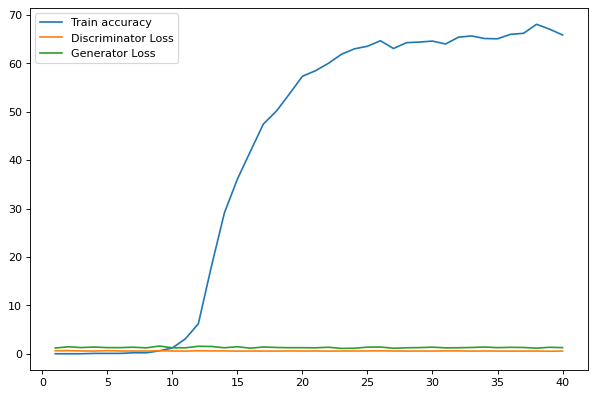

In [62]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][37])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#FR -> EN CSLS

39
71.0
80.27


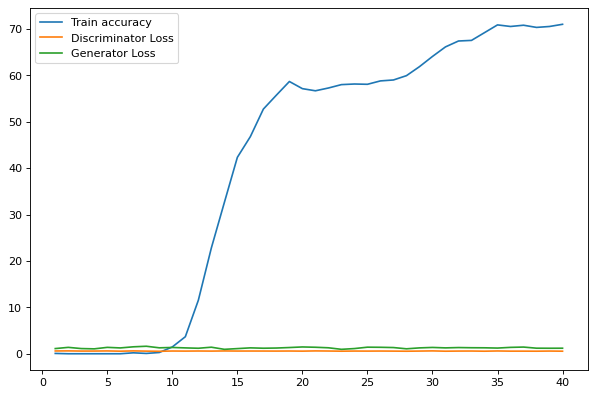

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][39])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#PL -> EN NN

39
21.33
56.2


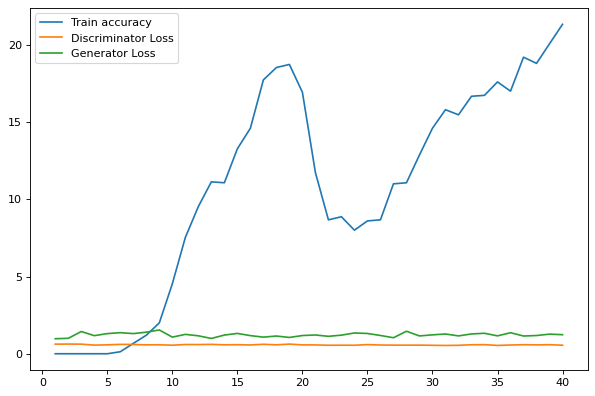

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][39])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#EN -> ID NN

21
66.53
79.8


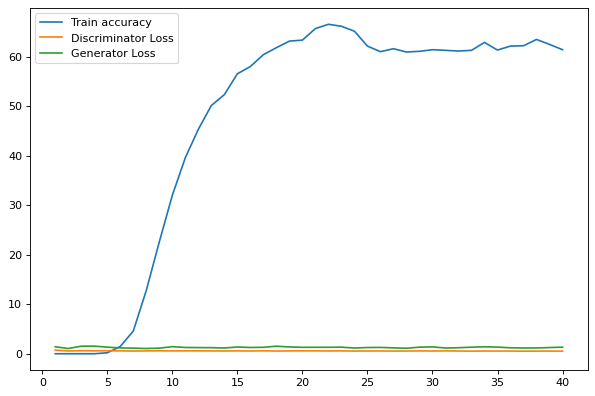

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][21])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#EN -> FR NN

26
56.27
74.67


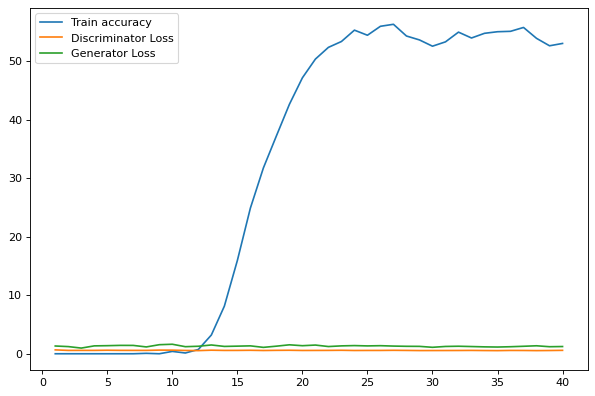

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][26])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#EN -> FR NN

28
66.53
77.4


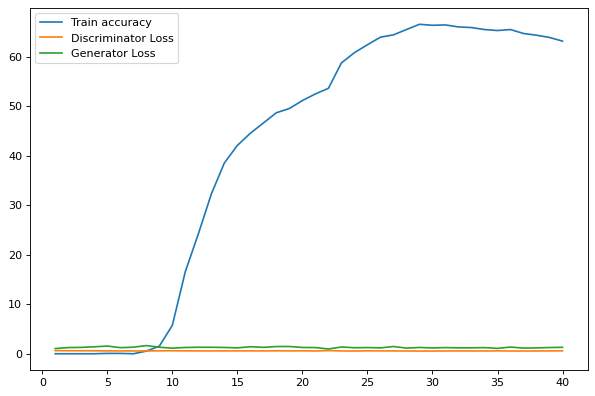

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][28])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#EN -> FR NN

34
73.07
81.6


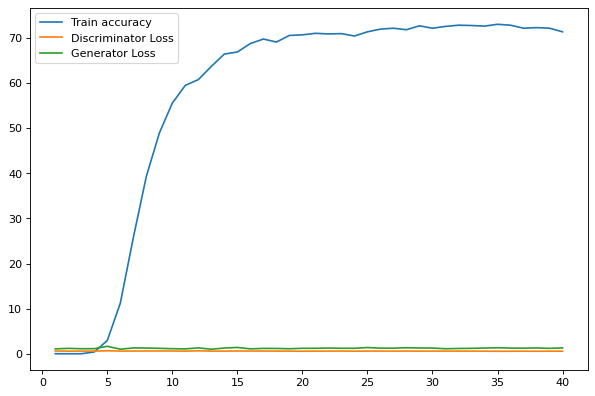

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][34])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#ES -> IT CSLS

35
35.53
65.2


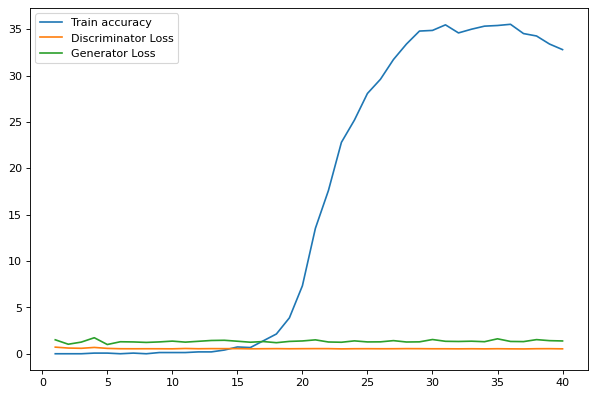

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][35])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#PL -> EN  CSLS

25
31.33
62.73


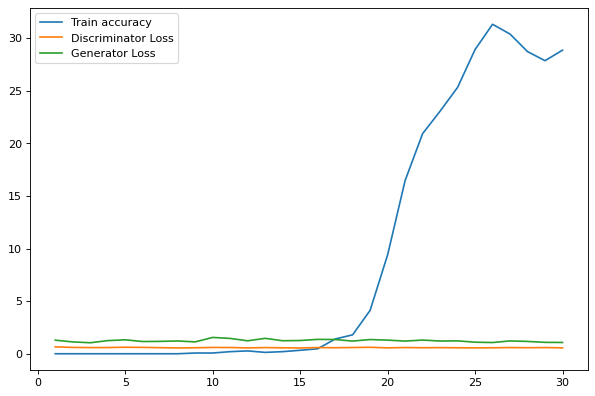

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][25])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#EN -> INDO CSLS

29
67.87
80.8


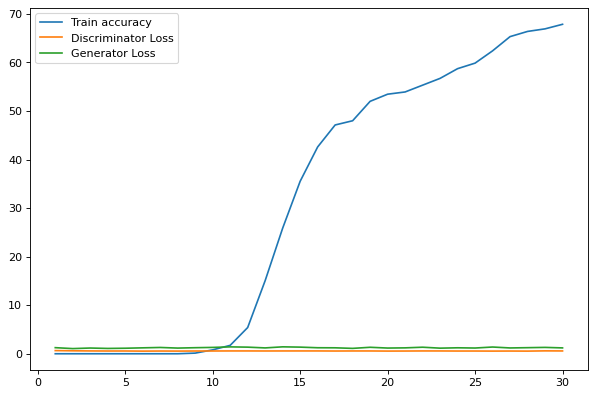

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][29])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#EN -> ES CSLS

29
63.13
76.73


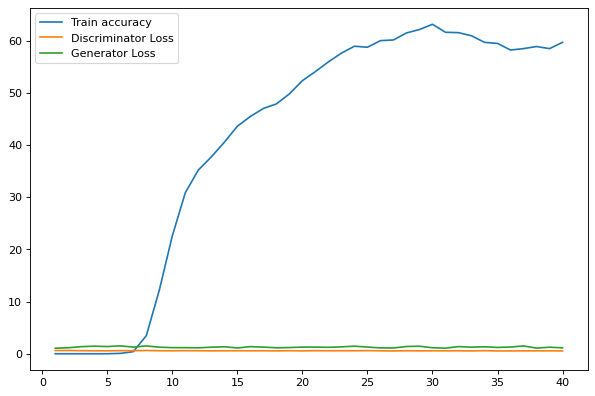

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][29])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

#EN -> IT CSLS

21
70.33
79.73


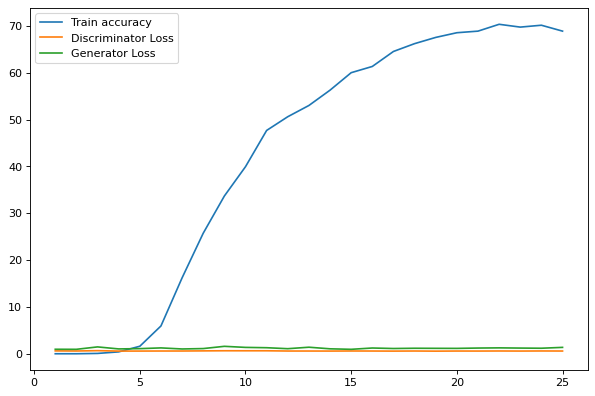

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][21])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

27
70.27
80.87


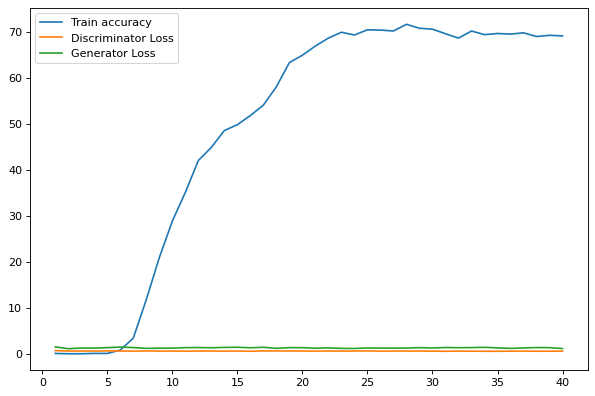

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][27])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

36
67.4
80.13


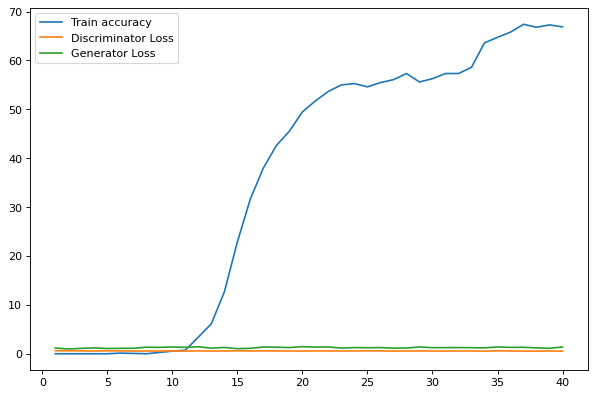

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][36])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

30
64.33
59.67


'ES -> EN'

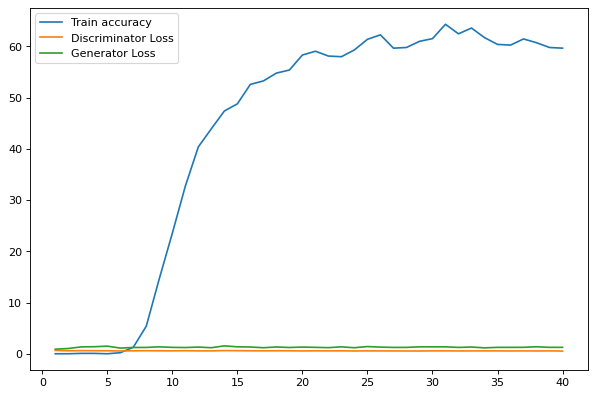

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][30])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_src_tgt_test))

"ES -> EN"

31
67.92
58.67


'EN -> ES'

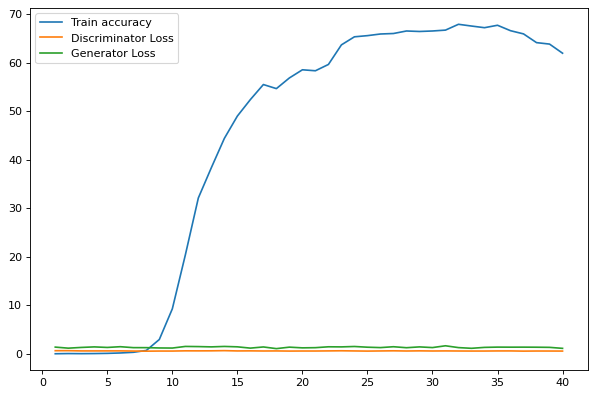

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][31])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_en_fr_test))

"EN -> ES"

28
62.94
56.47


'FR -> EN'

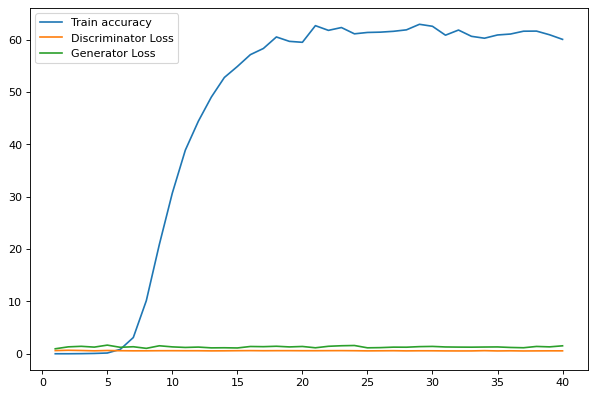

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][28])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_en_fr_test))

"FR -> EN"

9
61.98
41.13


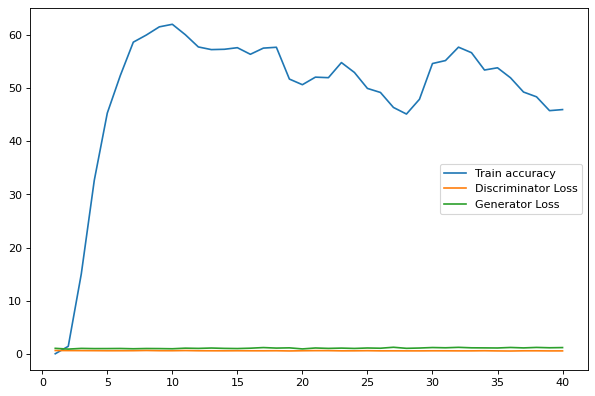

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
print(history["accuracy"][9])
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_en_fr_test))

22
(2943, 300)
52.2


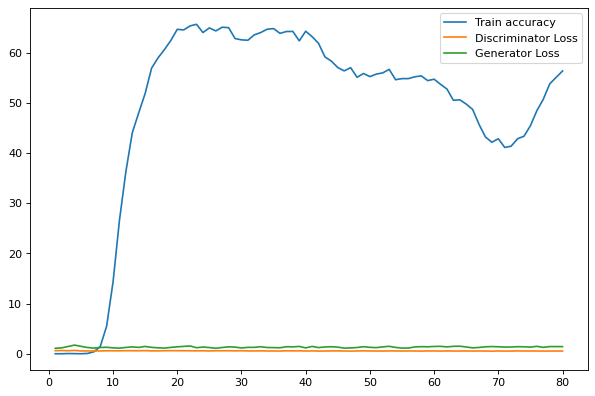

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))
preds = predict(np.array(list(df_test['SrcEmbed'])), targ_embeddings,  targ_id2word)
print(accuracy(df_test[0], preds, dico_en_fr_test))

19
5.340152885993524


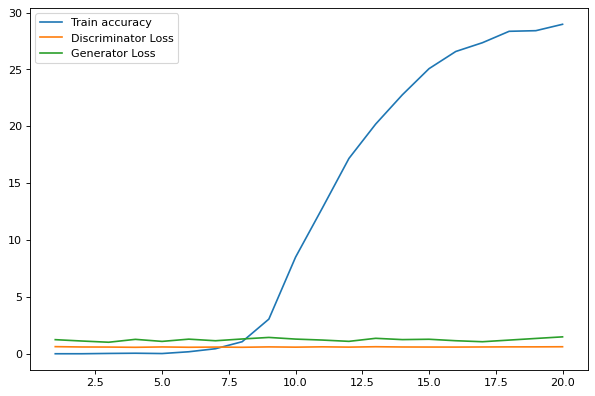

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history_norm['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history_norm["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history_norm["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history_norm["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history_norm["accuracy"]))
print(np.linalg.norm(np.array(list(df_test['TgtEmbed']))[0]))

24


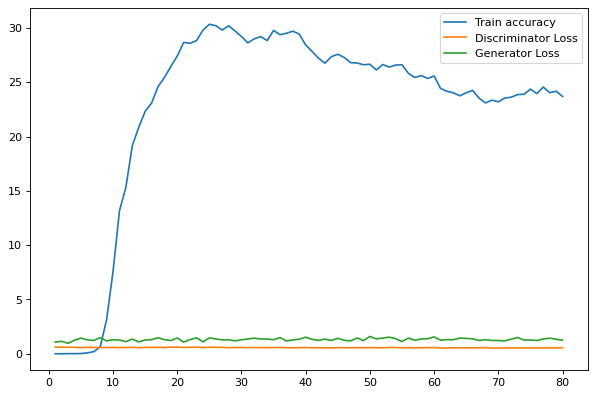

In [ ]:
import matplotlib.pyplot as plt 

history_size = len(history['accuracy'])
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(list(range(1, history_size+1)), history["accuracy"], label="Train accuracy")
plt.plot(list(range(1, history_size+1)), history["D_loss"], label="Discriminator Loss")
plt.plot(list(range(1, history_size+1)), history["G_loss"], label="Generator Loss")
plt.legend()
plt.show

print(np.argmax(history["accuracy"]))